<a href="https://colab.research.google.com/github/aksamban/learn-drl/blob/main/MAML_PPO_Implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
!pip install gymnasium
!pip install tqdm

Import Libraries and Initialize Classes

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Categorical
import random
from tqdm import tqdm

In [97]:
class PPO(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(PPO, self).__init__()
    self.fc1 = nn.Linear(input_dim, 64)
    self.fc2 = nn.Linear(64, 64)
    self.action_head = nn.Linear(64, output_dim)
    self.value_head = nn.Linear(64, 1)

  def forward(self, x, params=None):
    if params is None:
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      action_logits = self.action_head(x)
      value = self.value_head(x)
    else:
      x = F.relu(F.linear(x, params['fc1.weight'], params['fc1.bias']))
      x = F.relu(F.linear(x, params['fc2.weight'], params['fc2.bias']))
      action_logits = F.linear(x, params['action_head.weight'], params['action_head.bias'])
      value = F.linear(x, params['value_head.weight'], params['value_head.bias'])
    return action_logits, value

In [98]:
def PPO_Loss(logits, actions, advantages, values, target_values, value_loss_coef=0.5):
  dist = Categorical(logits=logits)
  log_probs = dist.log_prob(actions)
  policy_loss = -(log_probs * advantages).mean()
  value_loss = ((values - target_values) ** 2).mean()
  total_loss = policy_loss + value_loss_coef * value_loss
  return total_loss

In [99]:
def GAE(rewards, values, next_values, done, gamma=0.99, lambda_=0.95):
    # Compute TD errors (delta)
    deltas = rewards + gamma * next_values * (1 - done) - values
    advantages = torch.zeros_like(rewards)
    gae = 0
    for t in reversed(range(len(rewards))):
        gae = deltas[t] + gamma * lambda_ * gae * (1 - done[t])
        advantages[t] = gae
    return advantages

In [100]:
envs = ["MountainCar-v0", "CartPole-v1"]

In [101]:
max_input = 0
max_output = 0
for env in envs:
  e = gym.make(env)
  max_input = max(max_input, e.observation_space.shape[0])
  max_output = max(max_output, e.action_space.n)
model = PPO(input_dim=max_input, output_dim=max_output)

In [102]:
A = {name: param.clone() for name, param in model.named_parameters()}

In [103]:
def train(env, A, h):
  state, _ = env.reset()
  states, actions, rewards, dones, values, next_values = [], [], [], [], [], []

  for j in range(h):
    state_tensor = torch.tensor(state, dtype=torch.float32)

    if state_tensor.shape[0] < max_input:
      state_tensor = F.pad(state_tensor, (0, max_input - state_tensor.shape[0]))

    logits, value = model(state_tensor.unsqueeze(0))

    if max_output > env.action_space.n:
      zeros = max_output - env.action_space.n
      invalid_actions = [1]*env.action_space.n + [0]*zeros
      invalid_actions = torch.tensor(invalid_actions, dtype=torch.float32)
      logits = logits + (invalid_actions * 1e-10)

    action_dist = Categorical(logits=logits)
    action = action_dist.sample().item()
    action = min(max(action, 0), env.action_space.n - 1)  # Clip action to valid range

    next_state, reward, done, truncated, _ = env.step(action)
    next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
    if next_state_tensor.shape[0] < max_input:
      next_state_tensor = F.pad(next_state_tensor, (0, max_input - next_state_tensor.shape[0]))

    states.append(state_tensor)
    actions.append(action)
    rewards.append(reward)
    dones.append(done)
    values.append(value.squeeze(-1).item())

    if done or truncated:
      state, _ = env.reset()
      break
    else:
      state = next_state

  # Add the terminal state's value
  _, next_value = model(next_state_tensor.unsqueeze(0))
  next_values = values[1:] + [next_value.squeeze(-1).item()]

  # Convert to tensors
  states = torch.stack(states)
  actions = torch.tensor(actions)
  rewards = torch.tensor(rewards, dtype=torch.float32)
  values = torch.tensor(values, dtype=torch.float32)
  next_values = torch.tensor(next_values, dtype=torch.float32)
  dones = torch.tensor(dones, dtype=torch.float32)

  # Step 1: Compute advantages using GAE
  advantages = GAE(rewards, values, next_values, dones)

  # Step 2: Use A to compute B
  logits, value = model(states, params=A)  # Forward pass with A
  loss_A = PPO_Loss(logits, actions, advantages, value.squeeze(-1), next_values)  # Compute loss w.r.t A

  # Compute gradients for A and derive B
  grads_A = torch.autograd.grad(loss_A, A.values(), create_graph=True, allow_unused=True)

  return grads_A, loss_A

In [121]:
def task(A, k, h):
  name = envs[random.randint(0, len(envs)-1)]
  env = gym.make(name)
  loss_values = []

  for i in range(k):
    grads_A, _ = train(env, A, h)
    # Step 2: Use A to compute B
    B = {name: A[name] - 0.01 * grad for name, grad in zip(A.keys(), grads_A)}
    grads_B, loss_B = train(env, B, h)
    A = {name: A[name] - 0.01 * grad for name, grad in zip(A.keys(), grads_B)}
    loss_values.append(loss_B.item())

  env.close()
  return A, np.mean(loss_values)

In [124]:
epochs = 5000
epoch_losses = []
for epoch in tqdm(range(epochs), desc="Training", ncols=100):
  A, loss = task(A, 10, 5)
  epoch_losses.append(loss)

Training:  94%|██████████████████████████████████████████████▎  | 4724/5000 [12:22<00:43,  6.36it/s]


KeyboardInterrupt: 

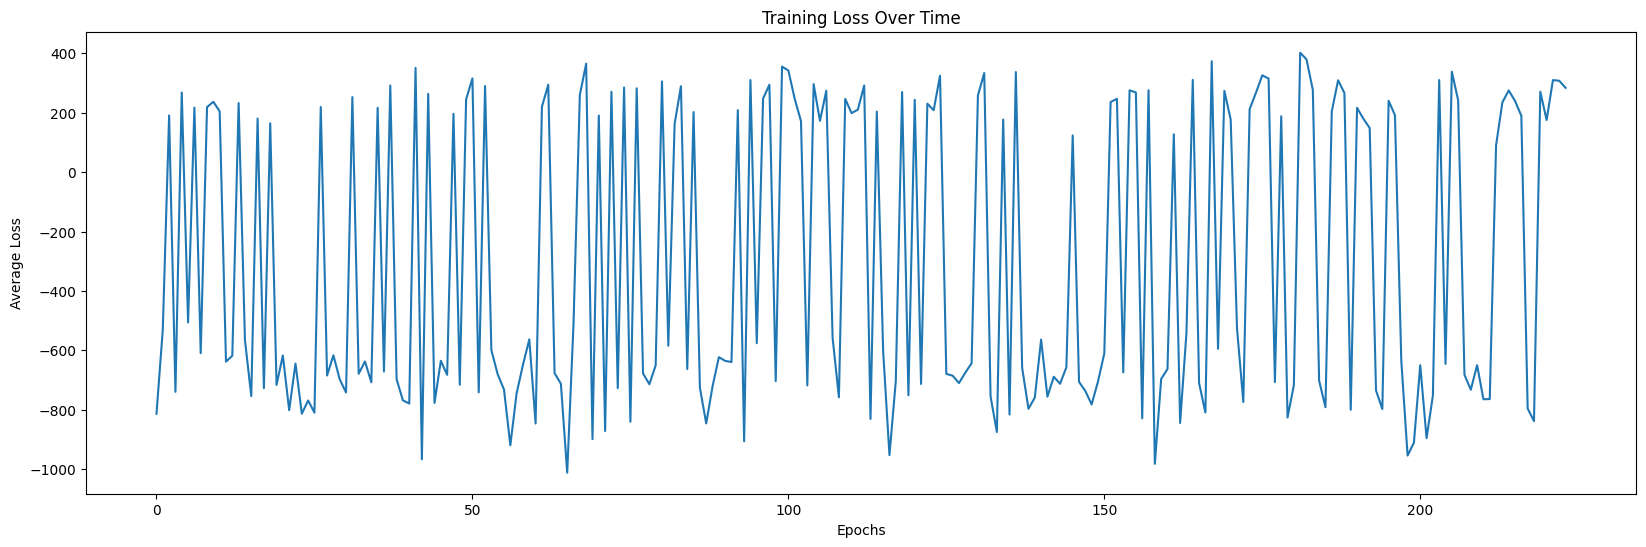

In [127]:
%matplotlib inline
plt.figure(figsize=(20, 6))
plt.plot(epoch_losses[4500:])
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.show()

In [128]:
torch.save(A, '4700_CarPole_1.pt')